## Mapping with GeoPandas

This is the accompanying notebook of this [blog entry](http://jose-coto.com/plotting-geopandas). Here we use the geopandas library to plot points got from Open Street Map to a shape file of the city of Lima. For more information, refer to the blog post.

In [2]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import geopandas.tools
from shapely.geometry import Point
import sqlite3
import seaborn as sns

In [3]:
#Getting bank data base
db = sqlite3.connect("/Users/Jose/Documents/Udacity/data_science/data_wrangling/Open_Street_project/Open_street_lima_project/lima_project")
#getting already stored shapefile
shp_lima = gp.GeoDataFrame.from_file('Lima_4326.shp')

In [4]:
#Simple map plot from shapefile
shp_lima.plot()

In [5]:
df_banks = pd.read_sql("""SELECT *
             FROM Node_tags JOIN (SELECT id, value FROM Node_tags WHERE key="name") as bank_vals 
             ON bank_vals.id=Node_tags.id, Nodes WHERE Node_tags.value="bank" and Nodes.id=Node_tags.id 
            """, con=db) 
df_banks["bank_names"] = df_banks["value"].iloc[:, 1]
df_banks = df_banks.drop(df_banks["value"], axis=1)

#Passing lan and lon to points
bank_points = df_banks[['lon', 'lat']].apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
geo_banks = gp.GeoDataFrame({"geometry": bank_points, "bank_names": df_banks["bank_names"]})

#You need to establish a coordinate system for the data you scraped.
geo_banks.crs = {'init': 'epsg:4326'}

(-12.600000000000001, -11.50000000000002)

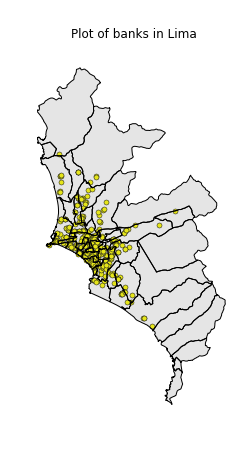

In [6]:
#Plotting location of all banks in Lima
plt.style.use("default")
%matplotlib inline
fig, ax = plt.subplots(1, figsize=(3.5,7))
base = shp_lima.plot(ax=ax, color='gray', alpha=0.2)
geo_banks.plot(ax=base, marker="o", mfc="yellow", markersize=5, markeredgecolor="black", zorder=0)
_ = ax.axis('off')
ax.set_title("Plot of banks in Lima")
ax.set_ylim(-12.600000000000001, -11.50000000000002)

In [7]:
#Performing Spatial Join
lima_banks = geopandas.tools.sjoin(geo_banks, shp_lima, how="right", op='intersects')

In [8]:
#Getting number of banks per district
num_banks_per_district = lima_banks.groupby("NOMBDIST").size()
num_banks_per_district = num_banks_per_district.to_frame(name="bank_num").reset_index()

#Establishing cut categories
num_banks_per_district["quant_cuts"] = pd.cut(num_banks_per_district["bank_num"], bins=[0, 10, 20, 30, 40, 100], 
              labels=["<=10", "<=20", "<=30","<=40", ">40"])
lima_bank_num = pd.merge(shp_lima, num_banks_per_district, on="NOMBDIST", how="right")

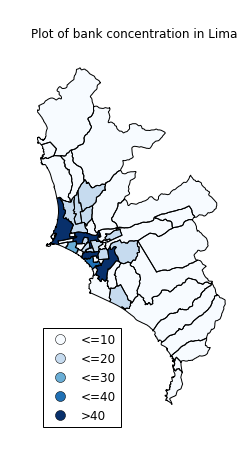

In [9]:
#Plotting concentration of banks in whole Lima
fig, ax = plt.subplots(1, figsize=(3.5,7))
lima_bank_num.plot(ax=ax, column='quant_cuts', cmap='Blues', alpha=1, legend=True)
ax.set_ylim(-12.600000000000001, -11.50000000000002)
_ = ax.axis('off')
ax.set_title("Plot of bank concentration in Lima")


In [10]:
#Getting center of San Isidro
center_san_isidro = lima_bank_num[lima_bank_num["NOMBDIST"]=="SAN ISIDRO"]["geometry"].centroid

In [11]:
#Filtering Data set to get only the banks within certain distance from San Isidro
less_away = lima_bank_num["geometry"].distance(center_san_isidro.values[0]) < 0.1
central_areas = lima_bank_num[less_away]

(-77.200000000000003, -76.7)

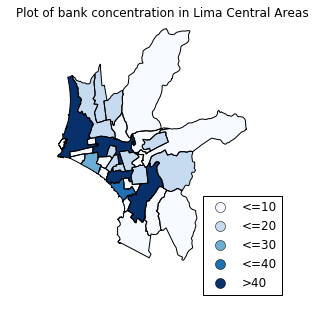

In [12]:
#Plotting banks within certain distance from San Isidro
fig, ax = plt.subplots(1, figsize=(4.5,5))
central_areas.plot(ax=ax, column='quant_cuts', cmap='Blues', alpha=1, legend=True)
_ = ax.axis('off')
ax.set_title("Plot of bank concentration in Lima Central Areas")
ax.set_ylim(-12.30)
ax.set_xlim(ax.get_xlim()[0], -76.70)